In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
featuresDF = pd.read_csv('data/featuresDF_test.csv')
sensorId = pd.read_csv('data/sensorId_test.csv')
vibState = pd.read_csv('data/vibState_test.csv')


In [4]:
featuresDF.values[:,1:1025]

array([[0.19026932591236484, 0.18310067393488846, 0.13266789221500985,
        ..., 0.1671427076182702, 0.1831079337322781, 0.17403654513612135],
       [0.17275100402780488, 0.14675893038178442, 0.12361566523473455,
        ..., 0.15153643786556667, 0.16686775722775524,
        0.15996720600044873],
       [0.1438959400730965, 0.11567400393293392, 0.13633691280126142,
        ..., 0.1278365312077604, 0.16744509331590074, 0.1753819107844247],
       ...,
       [0.07556861913012579, 0.14810913231229886, 0.14869611399033902,
        ..., 0.16696557674984136, 0.16545549039199373,
        0.15665604073624528],
       [0.06587958629914507, 0.16279217794603307, 0.19514960281229216,
        ..., 0.10894763845962298, 0.15580001126928567,
        0.1633813522988946],
       [0.0482213333411101, 0.13494151986820418, 0.13891789750807862,
        ..., 0.15469579463226396, 0.130641891893711, 0.1439047550134809]],
      dtype=object)

In [5]:
X = featuresDF.values[:,1:1025].astype(np.float32)
enc = OrdinalEncoder()
Y = enc.fit_transform(vibState.values)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)


In [7]:
pca = PCA(n_components=0.8)
X_condensed_pca = pca.fit_transform(X)
X_reconstructed_pca = pca.inverse_transform(X_condensed_pca)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

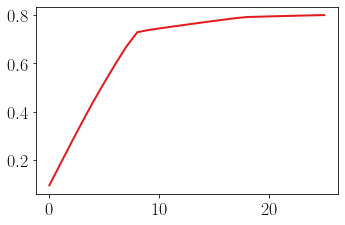

In [8]:
plt.plot(cumulative_variance)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 25)                537625    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1024)              539274    
Total params: 1,076,899
Trainable params: 1,076,899
Non-trainable params: 0
_________________________________________________________________
None


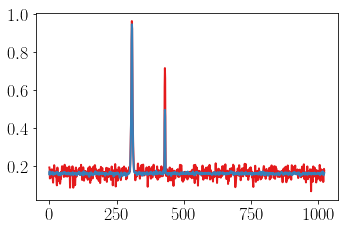

In [9]:
param_dict = {
    "hidden_nodes":[512,25],
    "input_shape":(1024,),
}
max_epochs = 20
batch_size = 32
verbose = 0

model = create_vanilla_ae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train,X_train,
            validation_data=(X_test,X_test),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=verbose)

X_reconstructed_vanilla_ae = model.predict(X)

print(model.summary())

plt.plot(X[0,:])
plt.plot(X_reconstructed_vanilla_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
model_21 (Model)                [(None, 100), (None, 627400      input_15[0][0]                   
__________________________________________________________________________________________________
model_22 (Model)                (None, 1024)         577024      model_21[1][2]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 512)          524800      input_15[0][0]                   
___________________________________________________________________________________________

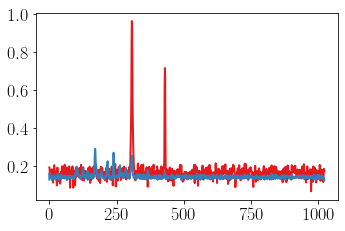

In [44]:
param_dict = {
    "hidden_nodes":[512],
    "input_shape":[1024,],
    "codings_size":100,
}

model,_,_ = create_vanilla_vae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train,X_train,
            validation_data=(X_test,X_test),
            epochs=50,
            batch_size=128,
            verbose=verbose)

X_reconstructed_vanilla_vae = model.predict(X)

model.summary()

plt.plot(X[0,:])
plt.plot(X_reconstructed_vanilla_vae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 25)                268825    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1024)              270474    
Total params: 539,299
Trainable params: 539,299
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.input

<tf.Tensor 'sequential_input:0' shape=(None, 1024) dtype=float32>

In [69]:
filters=[20,20]
kernels = [9,3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [64]
codings_size = 8

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model,vae_encoder,vae_decoder = create_conv_vae(param_dict)

In [70]:
model.compile(loss='binary_crossentropy',optimizer='adam')
history = model.fit(X_train[...,np.newaxis],X_train[...,np.newaxis],
                    epochs=20,batch_size=64,
                    validation_data=[X_test[...,np.newaxis],X_test[...,np.newaxis]])

Train on 1120 samples, validate on 280 samples
Epoch 1/20
1120/1120 [==============================] - 4s 3ms/sample - loss: 0.5550 - val_loss: 0.4606
Epoch 2/20
1120/1120 [==============================] - 0s 279us/sample - loss: 0.4693 - val_loss: 0.4472
Epoch 3/20
1120/1120 [==============================] - 0s 277us/sample - loss: 0.4554 - val_loss: 0.4467
Epoch 4/20
1120/1120 [==============================] - 0s 264us/sample - loss: 0.4505 - val_loss: 0.4463
Epoch 5/20
1120/1120 [==============================] - 0s 271us/sample - loss: 0.4479 - val_loss: 0.4462
Epoch 6/20
1120/1120 [==============================] - 0s 262us/sample - loss: 0.4465 - val_loss: 0.4460
Epoch 7/20
1120/1120 [==============================] - 0s 269us/sample - loss: 0.4458 - val_loss: 0.4461
Epoch 8/20
1120/1120 [==============================] - 0s 256us/sample - loss: 0.4456 - val_loss: 0.4462
Epoch 9/20
1120/1120 [==============================] - 0s 275us/sample - loss: 0.4454 - val_loss: 0.4462
E

In [71]:
X_reconstructed_cnn_vae = model.predict(X[...,np.newaxis])
print(X_reconstructed_cnn_vae[0,:].shape)
print(X[0,:].shape)


(1024, 1)
(1024,)


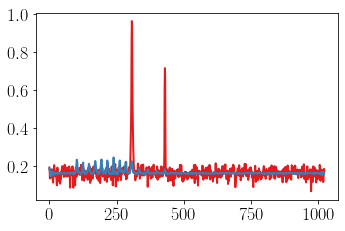

In [72]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_cnn_vae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [73]:
filters=[20]
kernels = [3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [32]
codings_size = 16

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model = create_conv_ae(param_dict)

In [74]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train[...,np.newaxis],X_train[...,np.newaxis],
                    epochs=40,batch_size=64,
                    validation_data=[X_test[...,np.newaxis],X_test[...,np.newaxis]])

Train on 1120 samples, validate on 280 samples
Epoch 1/40
1120/1120 [==============================] - 1s 1ms/sample - loss: 0.0981 - val_loss: 0.0920
Epoch 2/40
1120/1120 [==============================] - 0s 165us/sample - loss: 0.0608 - val_loss: 0.0469
Epoch 3/40
1120/1120 [==============================] - 0s 162us/sample - loss: 0.0236 - val_loss: 0.0087
Epoch 4/40
1120/1120 [==============================] - 0s 157us/sample - loss: 0.0107 - val_loss: 0.0029
Epoch 5/40
1120/1120 [==============================] - 0s 161us/sample - loss: 0.0097 - val_loss: 0.0031
Epoch 6/40
1120/1120 [==============================] - 0s 159us/sample - loss: 0.0090 - val_loss: 0.0043
Epoch 7/40
1120/1120 [==============================] - 0s 165us/sample - loss: 0.0084 - val_loss: 0.0035
Epoch 8/40
1120/1120 [==============================] - 0s 153us/sample - loss: 0.0078 - val_loss: 0.0027
Epoch 9/40
1120/1120 [==============================] - 0s 161us/sample - loss: 0.0068 - val_loss: 0.0020
E

In [75]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 512, 20)           160       
_________________________________________________________________
sequential_19 (Sequential)   (None, 1024, 1)           1281      
Total params: 1,441
Trainable params: 1,401
Non-trainable params: 40
_________________________________________________________________


In [76]:
X_reconstructed_cnn_ae = model.predict(X[...,np.newaxis])
print(X_reconstructed_cnn_ae[0,:].shape)
print(X[0,:].shape)

(1024, 1)
(1024,)


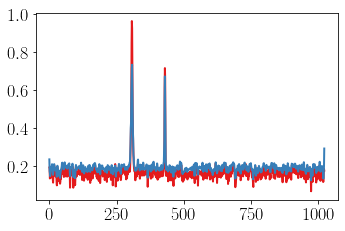

In [77]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_cnn_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [66]:
from tensorflow.keras import backend as K
from tensorflow import keras


class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

codings_size = 5

inputs = keras.layers.Input(shape=[1024])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(1024, activation="sigmoid")(x)
outputs = keras.layers.Reshape([1024])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 1024.)
variational_ae.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=[rounded_accuracy])
# variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=64,
                             validation_data=[X_test, X_test],verbose=1)

Train on 1120 samples, validate on 280 samples
Epoch 1/50
1120/1120 [==============================] - 1s 504us/sample - loss: 0.0568 - rounded_accuracy: 0.8805 - val_loss: 0.0143 - val_rounded_accuracy: 0.9948
Epoch 2/50
1120/1120 [==============================] - 0s 75us/sample - loss: 0.0117 - rounded_accuracy: 0.9950 - val_loss: 0.0103 - val_rounded_accuracy: 0.9948
Epoch 3/50
1120/1120 [==============================] - 0s 73us/sample - loss: 0.0104 - rounded_accuracy: 0.9948 - val_loss: 0.0111 - val_rounded_accuracy: 0.9948
Epoch 4/50
1120/1120 [==============================] - 0s 74us/sample - loss: 0.0091 - rounded_accuracy: 0.9948 - val_loss: 0.0108 - val_rounded_accuracy: 0.9948
Epoch 5/50
1120/1120 [==============================] - 0s 76us/sample - loss: 0.0081 - rounded_accuracy: 0.9950 - val_loss: 0.0071 - val_rounded_accuracy: 0.9948
Epoch 6/50
1120/1120 [==============================] - 0s 75us/sample - loss: 0.0074 - rounded_accuracy: 0.9948 - val_loss: 0.0073 - val

In [67]:
X_predicted = variational_ae.predict(X)

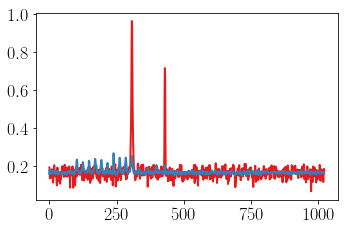

In [68]:
plt.plot(X[0,:])
plt.plot(X_predicted[0,:])
